<div style="background-color:#342184; padding:6px; color:#f3f0ff;">

# Try Finesse 2 & PyKat

</div>

In this interactive notebook we introduce some key aspects of  <a href=http://www.gwoptics.org/finesse/>Finesse</a> and <a href =http://www.gwoptics.org/pykat/> PyKat</a>.
You can play around with the live code presented here, create your own notebook (`File > New Notebook`), or upload a notebook you wish to test-run. Note that **changes are not saved after exiting the Binder session**, so you should download a local copy of any notebooks you wish to retain.

### In this notebook

Finesse numerically models optical systems in the _frequency domain_ using <a href = https://en.wikipedia.org/wiki/Plane_wave>plane waves</a> or <a href=https://en.wikipedia.org/wiki/Gaussian_beam>Gaussian beams</a>, including higher-order modes.

This notebook demonstrates a common task: modeling a 2-mirror optical cavity. It is based on material from the <a href=http://www.gwoptics.org/learn/index.html>Learn Laser Interferometry</a> course on gwoptics.org. We will:
1. Construct a plane-waves model of the cavity, plotting the power transmitted, reflected, and circulating from the cavity as its length is changed. 
2. Make the model more realistic using Gaussian beams and curved optics, then re-produce the powers plot to check that the behaviour still makes sense.
3. Plot the profile of the beam transmitted from the cavity.
4. Show that the cavity can be used as a mode cleaner.

You can learn more about 2-mirror cavities, also known as Fabry-Perot  cavities or interferometers, by reading <a href=https://link.springer.com/article/10.1007/s41114-016-0002-8#Sec33>section 5.1</a> of Interferometer Techniques for Gravitational-Wave Detection and <a href=http://www.gwoptics.org/learn/02_Plane_waves/01_Fabry_Perot_cavity/index.html>section 2</a> of the Learn Laser Interferometry course.

## Getting Started

You may wish to first read through <a href="http://www.gwoptics.org/learn/01_Introduction/01_Getting_Started/index.html">Getting Started</a> for a general introduction to Jupyter notebooks, Finesse and Pykat. 

Typical packages needed in simple Finesse/PyKat simulations:

(type shift+enter to run)

In [1]:
from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.92          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## Optical Layout

The setup we want to model is shown in the figure below. A *cavity*, or *optical resonator* is formed by the two partially-transparent mirrors M1 and M2. To measure the reflected, transmitted, and circulating power in the cavity, we add 3 photodiodes (these do not affect the beam propagation).

<img src=http://www.gwoptics.org/learn/02_Plane_waves/01_Fabry_Perot_cavity/fabry-perot.svg>


In our case we have:

```
                       M1                     M2
laser (n0) ------> (n1)|(n2) <----------> (n3)|(n4)
```

and will add photodiodes looking at the beams at nodes `n1` (refl), `n3` (circ) and `n4` (trans).

## Plane-Waves Finesse Model

### base model
The code below builds a plane-waves model with:
 * 1 W laser with 0 offset to the default wavelength (This is 1064nm in Finesse, unless you tell it otherwise)
 * a short space from laser to M1
 * mirrors 'M1' and 'M2' with T=0.15 and zero loss
 * a cavity length of 1 meter.
 
You may find the <a href=http://www.gwoptics.org/finesse/reference/>Finesse syntax reference</a> helpful for interpreting `basecode`, and the <a href=http://www.gwoptics.org/finesse/reference/cheatsheet.php>Cheatsheet</a> useful for understanding definitional conventions, e.g. lengths vs 'tunings' (`phi`).

In [9]:
#Finesse code for the optical layout
basecode = """
l laser 1 0 n0
s s0 0.1 n0 n1

#the cavity:
m1 M1 0.15 0 0 n1 n2
s scav 1 n2 n3
m1 M2 0.15 0 30 n3 n4
"""

#initialise Finesse with a new empty kat object
basekat = finesse.kat() 
#tell Finesse to talk less
basekat.verbose = False
#parse the Finesse code into PyKat
basekat.parse(basecode)

### plotting powers
Here we make a copy of the `basekat` object, add the three detectors as noted in the sketches above, then add an `xaxis` command to vary the tuning of M2 over a range of one wavelength. 

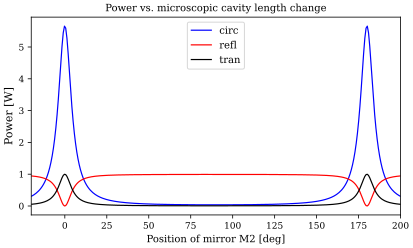

In [10]:
#create an independent copy of basekat
kat1 = basekat.deepcopy()
#write the code for the PDs and xaxis
PDcode = """
# Photo diodes measuring DC-power
pd refl n1          # Reflected field
pd circ n3          # Circulating field
pd tran n4          # Transmitted field

## Simulation instructions ##
xaxis M2 phi lin -20 200 300    # Varying tuning of input mirror m2.
yaxis abs                       # Plotting the amplitude of the detector measurements. 
"""
#parse the code for the new PDs and xaxis to the copied kat object 
kat1.parse(PDcode)
#run the simulation, and store the result in out1
out1 = kat1.run()
#plot the output of all detectors in kat1
out1.plot(xlabel='Position of mirror M2 [deg]',
          ylabel='Power [W]', 
          title = 'Power vs. microscopic cavity length change')

## Gaussian Finesse Model
    
###  instructing Finesse to use Gaussian beams, add curvatures to the cavity mirrors, and reproduce the tuning plot for the upgraded model

Below we make a new copy of `basekat` and parse additional code to:
 - add curvatures of $Rc_1$=-0.6m, $Rc_2$=0.6m to mirrors M1 and M2 respectively 
 - calculate the coupling of fields considering the HG00 mode only
 - define the cavity formed by M1 and M2
 - plot the powers again to check the the cavity still behaves as we expect.

See the <a href=http://www.gwoptics.org/finesse/reference/cheatsheet.php>Cheatsheet</a> for the RoC sign convention and overview of the `cav` command.

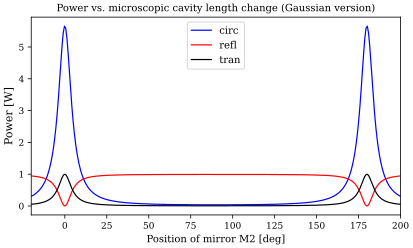

In [11]:
#make a copy of the base
gausskat = basekat.deepcopy()
#parse the required commands
gausskat.parse("""
attr M1 Rc -0.6
attr M2 Rc 0.6
cav FPcav M1 n2 M2 n3
maxtem 0
""")
#make a copy we can play with
kat2 = gausskat.deepcopy()
#parse the code for the PDs again
kat2.parse(PDcode)
#run the code
out2 =kat2.run()
#plot the result
out2.plot(xlabel='Position of mirror M2 [deg]',
          ylabel='Power [W]', 
          title = 'Power vs. microscopic cavity length change (Gaussian version)')

###  transmitted beam profile

/tmp/ipykernel_574218/1880977144.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(out3.x, out3.y,out3["BP"], shading='auto')


Text(0, 0.5, 'y position [# spotsizes]')

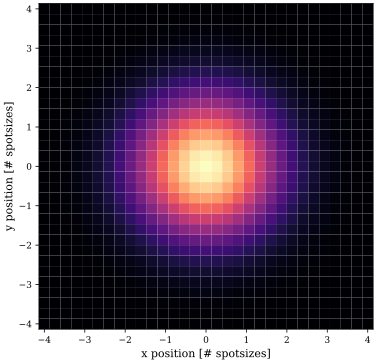

In [12]:
#pykat commands for the beam profiler
kat3 = gausskat.deepcopy()
kat3.parse("""
beam BP n4
xaxis BP x lin -4 4 30
x2axis BP y lin -4 4 30""")
out3=kat3.run()

#making the plot
plt.figure(figsize=(6,6)) #making sure the image is square
plt.pcolormesh(out3.x, out3.y,out3["BP"], shading='auto')
plt.xlabel("x position [# spotsizes]")
plt.ylabel("y position [# spotsizes]")

  
### Mode cleaning

The code below does the following:
1. use the `tem` command to add some higher order mode content to the input beam.
2. Plots the resulting beam profile at the input node. 
3. Plots the cavity powers with tuning.
4. Plots the beam profile transmitted from the cavity at several different tunings of interest, to confirm that that cavity 'cleans' the beam.

/tmp/ipykernel_574218/1081436378.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(mcout1.x, mcout1.y,mcout1["BP"])


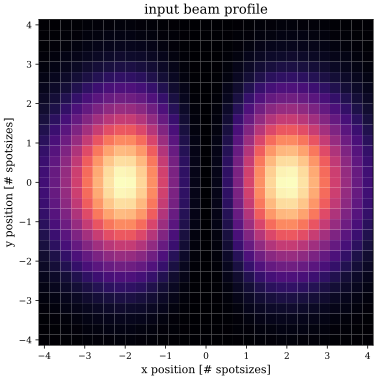

<Figure size 540x333.72 with 0 Axes>

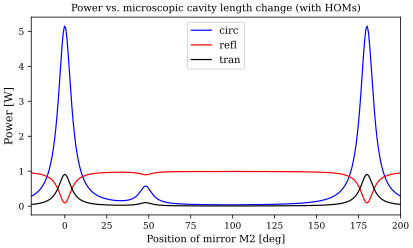

/tmp/ipykernel_574218/1081436378.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(mcout3.x, mcout3.y,mcout3["BP"], shading='auto')
/tmp/ipykernel_574218/1081436378.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(mcout4.x, mcout4.y,mcout4["BP"], shading='auto')


Text(0.5, 1.0, 'output beam profile, 70deg')

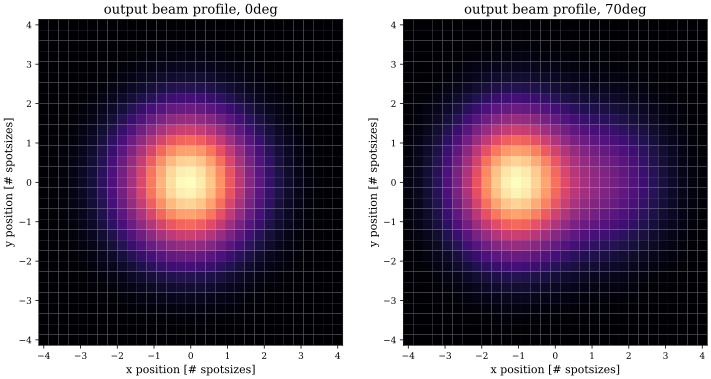

In [6]:
# add some HOMs 
MCkat = gausskat.deepcopy()
MCkat.parse("""
tem laser 1 0 0.1 0
maxtem 3
""")

# input beam profile
mckat1 = MCkat.deepcopy()
mckat1.parse("""
beam BP n0
xaxis BP x lin -4 4 30
x2axis BP y lin -4 4 30""")
mcout1 = mckat1.run()
#plot
plt.figure(figsize=(6,6)) #making sure the image is square
plt.pcolormesh(mcout1.x, mcout1.y,mcout1["BP"])
plt.xlabel("x position [# spotsizes]")
plt.ylabel("y position [# spotsizes]")
plt.title("input beam profile")

#cavity tuning vs powers
mckat2 = MCkat.deepcopy()
mckat2.parse(PDcode)
mcout2 = mckat2.run()
#plot
plt.figure()
mcout2.plot(xlabel='Position of mirror M2 [deg]',
          ylabel='Power [W]', 
          title = 'Power vs. microscopic cavity length change (with HOMs)')

#transmitted profiles at interesting tunings
#no detuning
mckat3 = MCkat.deepcopy()
mckat3.parse("""
beam BP n4
xaxis BP x lin -4 4 30
x2axis BP y lin -4 4 30""")
mcout3 = mckat3.run()
#70deg detuning
mckat4 = mckat3.deepcopy()
mckat4.M2.phi = 70
mcout4 = mckat4.run()
#plots
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pcolormesh(mcout3.x, mcout3.y,mcout3["BP"], shading='auto')
plt.xlabel("x position [# spotsizes]")
plt.ylabel("y position [# spotsizes]")
plt.title("output beam profile, 0deg")
plt.subplot(1,2,2)
plt.pcolormesh(mcout4.x, mcout4.y,mcout4["BP"], shading='auto')
plt.xlabel("x position [# spotsizes]")
plt.ylabel("y position [# spotsizes]")
plt.title("output beam profile, 70deg")

##### A note on pykat and finesse commands:

Here, we have largely used pykat to just parse code written in *Finesse* syntax (`kat.parse("<FINESSE_SYNTAX>")`) and to plot the outputs.

Many commands also have a direct equivalent in pykat, and pykat has many additional features which become more useful once the base kat object has been created. Some examples:

 - `kat.M1.phi = 10` --sets the tuning of M1 to 10$^\circ$
 - `kat.M2.setRTL(1,0,0)` --sets the power Reflectivity, Transmissivity, and Loss of M2 to 1, 0, and 0 respectively
 - `kat.noxaxis = True` --tells the code to ignore any xaxis command and just compute the detector outputs for the current parameters
 - `kat.maxtem = 6` --changes the number of HOMs included in the model to include all HG modes up to 6th order.